Experiments with cython (perf x100)

In [4]:
import math
import time
import bisect

import pandas as pd
import numpy as np
import plotly as plt
import ray

pd.options.plotting.backend = "plotly"

import sys, os, os.path

sys.path.append(os.path.expanduser("../src"))

from generate_common import custom_ray_init, cache_load
from src.spinorama.filter_iir import Biquad
from src.spinorama.filter_peq import peq_print, peq_format_apo, peq_build
import scipy.optimize as opt

In [ ]:
custom_ray_init({"--log-level": "INFO"})

In [ ]:
# speaker_name = "Genelec 8341A"
# speaker_origin = "ASR"
# speaker_version = "asr-vertical"
# speaker_name = "BIC America FH6-LCR Center"
# speaker_origin = "ASR"
# speaker_version = "asr-vertical"
# speaker_name = "Arendal Sound 1961 Center"
speaker_name = "KEF R8 Meta"
# speaker_name = "JBL AC25"
speaker_origin = "ASR"
speaker_version = "asr"
df_speaker = cache_load({"speaker_name": speaker_name, "origin": speaker_origin}, False)
ray.shutdown()

In [ ]:
spl_h = df_speaker[speaker_name][speaker_origin][speaker_version]["SPL Horizontal_unmelted"]
spl_v = df_speaker[speaker_name][speaker_origin][speaker_version]["SPL Vertical_unmelted"]

from src.spinorama.compute_cea2034 import compute_cea2034, estimated_inroom_hv

%timeit compute_cea2034(spl_h, spl_v)
%timeit estimated_inroom_hv(spl_h, spl_v)

python_spin = compute_cea2034(spl_h, spl_v)
python_pir = estimated_inroom_hv(spl_h, spl_v)

freq = spl_h.Freq
spl_h = spl_h.drop("Freq", axis=1)
spl_v = spl_v.drop("Freq", axis=1)
spl = np.concatenate((spl_h.T.to_numpy(), spl_v.T.to_numpy()), axis=0)

In [ ]:
%load_ext Cython

In [ ]:
def compute_area_q(alpha_d: float, beta_d: float) -> float:
    """Compute the area of the sphere between 4 lines at alpha and beta angles"""
    alpha = alpha_d * 2 * math.pi / 360
    beta = beta_d * 2 * math.pi / 360
    gamma = math.acos(math.cos(alpha) * math.cos(beta))
    A = math.atan(math.sin(beta) / math.tan(alpha))
    B = math.atan(math.sin(alpha) / math.tan(beta))
    C = math.acos(-math.cos(A) * math.cos(B) + math.sin(A) * math.sin(B) * math.cos(gamma))
    S = 4 * C - 2 * math.pi
    # print('gamma {} A {} B {} C {} S {}'.format(
    #    gamma*360/2/math.pi, A*360/2/math.pi, B*360/2/math.pi, C*360/2/math.pi, S))
    return S


def compute_weigths() -> list[float]:
    """Compute the weigths from the CEA2034 standards"""
    angles = [i * 10 + 5 for i in range(0, 9)] + [90]
    weigth_angles = [compute_area_q(i, i) for i in angles]
    # weigths are the delta between 2 consecutive areas
    weigths = [weigth_angles[0]] + [
        weigth_angles[i] - weigth_angles[i - 1] for i in range(1, len(weigth_angles))
    ]
    weigths[9] *= 2.0
    return weigths


std_weigths = compute_weigths()

sp_weigths = {
    "On Axis": std_weigths[0],
    "180°": std_weigths[0],
    "-180°": std_weigths[0],
    #
    "10°": std_weigths[1],
    "170°": std_weigths[1],
    "-170°": std_weigths[1],
    "-10°": std_weigths[1],
    #
    "20°": std_weigths[2],
    "160°": std_weigths[2],
    "-160°": std_weigths[2],
    "-20°": std_weigths[2],
    #
    "30°": std_weigths[3],
    "150°": std_weigths[3],
    "-150°": std_weigths[3],
    "-30°": std_weigths[3],
    #
    "40°": std_weigths[4],
    "140°": std_weigths[4],
    "-140°": std_weigths[4],
    "-40°": std_weigths[4],
    #
    "50°": std_weigths[5],
    "130°": std_weigths[5],
    "-130°": std_weigths[5],
    "-50°": std_weigths[5],
    #
    "60°": std_weigths[6],
    "120°": std_weigths[6],
    "-120°": std_weigths[6],
    "-60°": std_weigths[6],
    #
    "70°": std_weigths[7],
    "110°": std_weigths[7],
    "-110°": std_weigths[7],
    "-70°": std_weigths[7],
    #
    "80°": std_weigths[8],
    "100°": std_weigths[8],
    "-100°": std_weigths[8],
    "-80°": std_weigths[8],
    #
    "90°": std_weigths[9],
    "-90°": std_weigths[9],
}


def octave(N: int) -> list[tuple[float, float, float]]:
    """compute 1/N octave band

    N: >=2 when N increases, bands are narrower
    """
    # why 1290 and not 1000?
    reference = 1290.0
    p = pow(2, 1 / N)
    p_band = pow(2, 1 / (2 * N))
    o_iter = int((N * 10 + 1) / 2)
    center = (
        [reference / p**i for i in range(o_iter, 0, -1)]
        + [reference]
        + [reference * p**i for i in range(1, o_iter + 1, 1)]
    )
    return [(c / p_band, c, c * p_band) for c in center]


intervals = [
    (np.searchsorted(freq, omin, side="right"), np.searchsorted(freq, omax, side="left"))
    for omin, ocenter, omax in octave(2)
    if 100 <= ocenter <= 12000
]

In [ ]:
spl_keys = [f"H{k}" for k in spl_h] + [f"V{k}" for k in spl_v]
weigths = [sp_weigths[k] for k in spl_h] + [sp_weigths[k] for k in spl_v]


def build_index(spl_key, h_key, v_key):
    idx = [spl_key.index(f"H{k}") for k in h_key] + [spl_key.index(f"V{k}") for k in v_key]
    return idx


idx_lw = build_index(
    spl_keys, ["10°", "20°", "30°", "-10°", "-20°", "-30°"], ["On Axis", "10°", "-10°"]
)
idx_er = build_index(
    spl_keys,
    [
        "On Axis",
        "10°",
        "20°",
        "30°",
        "40°",
        "50°",
        "60°",
        "70°",
        "80°",
        "90°",
        "100°",
        "110°",
        "120°",
        "130°",
        "140°",
        "150°",
        "160°",
        "170°",
        "-10°",
        "-20°",
        "-30°",
        "-40°",
        "-50°",
        "-60°",
        "-70°",
        "-80°",
        "-90°",
        "100°",
        "110°",
        "120°",
        "130°",
        "140°",
        "150°",
        "160°",
        "170°",
        "180°",
    ],
    ["On Axis", "-20°", "-30°", "-40°", "40°", "50°", "60°"],
)
idx_floor_bounce = build_index(spl_keys, [], ["-20°", "-30°", "-40°"])
idx_ceiling_bounce = build_index(spl_keys, [], ["40°", "50°", "60°"])
idx_front_wall_bounce = build_index(
    spl_keys, ["On Axis", "-10°", "-20°", "-30°", "10°", "20°", "30°"], []
)
idx_side_wall_bounce = build_index(
    spl_keys, ["-40°", "-50°", "-60°", "-70°", "-80°", "40°", "50°", "60°", "70°", "80°"], []
)
idx_rear_wall_bounce = build_index(
    spl_keys,
    [
        "-170°",
        "-160°",
        "-150°",
        "-140°",
        "-130°",
        "-120°",
        "-110°",
        "-100°",
        "-90°",
        "90°",
        "100°",
        "110°",
        "120°",
        "130°",
        "140°",
        "150°",
        "160°",
        "170°",
        "180°",
    ],
    [],
)
idx_tvr = build_index(spl_keys, [], ["On Axis", "-20°", "-30°", "-40°", "40°", "50°", "60°"])
idx_fr = build_index(spl_keys, [], ["On Axis", "-20°", "-30°", "-40°"])
idx_cr = build_index(spl_keys, [], ["On Axis", "40°", "50°", "60°"])
idx_front = build_index(spl_keys, ["On Axis", "10°", "20°", "30°", "-10°", "-20°", "-30°"], [])
idx_side = build_index(
    spl_keys, ["40°", "50°", "60°", "70°", "80°", "-40°", "-50°", "-60°", "-70°", "-80°"], []
)
idx_rear = build_index(
    spl_keys,
    [
        "90°",
        "100°",
        "110°",
        "120°",
        "130°",
        "140°",
        "150°",
        "160°",
        "170°",
        "-90°",
        "-100°",
        "-110°",
        "-120°",
        "-130°",
        "-140°",
        "-150°",
        "-160°",
        "-170°",
        "180°",
    ],
    [],
)
idx_thr = build_index(
    spl_keys,
    [
        "On Axis",
        "10°",
        "20°",
        "30°",
        "40°",
        "50°",
        "60°",
        "70°",
        "80°",
        "90°",
        "100°",
        "110°",
        "120°",
        "130°",
        "140°",
        "150°",
        "160°",
        "170°",
        "-10°",
        "-20°",
        "-30°",
        "-40°",
        "-50°",
        "-60°",
        "-70°",
        "-80°",
        "-90°",
        "-100°",
        "-110°",
        "-120°",
        "-130°",
        "-140°",
        "-150°",
        "-160°",
        "-170°",
        "180°",
    ],
    [],
)
idx_sp = build_index(
    spl_keys,
    [
        "On Axis",
        "10°",
        "20°",
        "30°",
        "40°",
        "50°",
        "60°",
        "70°",
        "80°",
        "90°",
        "100°",
        "110°",
        "120°",
        "130°",
        "140°",
        "150°",
        "160°",
        "170°",
        "-10°",
        "-20°",
        "-30°",
        "-40°",
        "-50°",
        "-60°",
        "-70°",
        "-80°",
        "-90°",
        "-100°",
        "-110°",
        "-120°",
        "-130°",
        "-140°",
        "-150°",
        "-160°",
        "-170°",
        "180°",
    ],
    [
        "10°",
        "20°",
        "30°",
        "40°",
        "50°",
        "60°",
        "70°",
        "80°",
        "90°",
        "100°",
        "110°",
        "120°",
        "130°",
        "140°",
        "150°",
        "160°",
        "170°",
        "-10°",
        "-20°",
        "-30°",
        "-40°",
        "-50°",
        "-60°",
        "-70°",
        "-80°",
        "-90°",
        "-100°",
        "-110°",
        "-120°",
        "-130°",
        "-140°",
        "-150°",
        "-160°",
        "-170°",
    ],
)
idx_cea2034 = [
    idx_lw,  # 0
    idx_er,  # 1
    idx_floor_bounce,  # 2
    idx_ceiling_bounce,  # 3
    idx_front_wall_bounce,  # 4
    idx_side_wall_bounce,  # 5
    idx_rear_wall_bounce,  # 6
    idx_tvr,  # 7
    idx_fr,  # 8
    idx_cr,  # 9
    idx_front,  # 10
    idx_side,  # 11
    idx_rear,  # 12
    idx_thr,  # 13
    idx_sp,  # 14
]

In [ ]:
%%cython
import math
cimport numpy as np
import numpy as np
from more_itertools import consecutive_groups
from scipy.stats import linregress

np.import_array()

cdef double[:] spl2pressure(const double[:] spl):
    return np.power(10, np.divide(np.subtract(spl,105.0),20))

cdef double[:] pressure2spl(const double[:] pressure):
    return np.add(np.multiply(np.log10(pressure), 20), 105)

cpdef double[:,:] spl2pressure2(const double[:,:] spl):
    cdef p2 = np.zeros_like(spl)
    cdef Py_ssize_t i
    for i in range(spl.shape[0]):
        # spl 2 pressure and then square it
        p2[i] = np.square(spl2pressure(spl[i]))
    return p2


cdef double[:] apply_rms(const double[:,:] p2, idx):
    cdef Py_ssize_t len_idx = len(idx)
    cdef double[:] rms = np.zeros(p2.shape[1])
    cdef Py_ssize_t i
    for i in range(len_idx):
        rms = np.add(rms, p2[idx[i]])
    return pressure2spl(np.sqrt(np.divide(rms, len_idx)))


cdef double[:] apply_weigthed_rms(const double[:,:] p2, idx, const double[:] weigths):
    cdef Py_ssize_t len_idx = len(idx)
    cdef double[:] rms = np.zeros(p2.shape[1])
    cdef double sum_weigths = 0.0
    cdef Py_ssize_t i
    for i in range(len_idx):
        rms = np.add(rms, np.multiply(p2[idx[i]],weigths[idx[i]]))
        sum_weigths += weigths[idx[i]]
    return pressure2spl(np.sqrt(np.divide(rms, sum_weigths)))

cpdef c_cea2034(const double[:,:] spl, idx, const double[:] weigths):
    cdef Py_ssize_t len_spl = len(spl[0])
    cdef pressure2 = spl2pressure2(spl)
    cdef cea2034 = np.zeros([len(idx)+1, len_spl])
    cdef Py_ssize_t idx_lw = 0
    cdef Py_ssize_t idx_er = 1
    cdef Py_ssize_t idx_sp = len(idx)-1
    cdef Py_ssize_t idx_pir = idx_sp+1
    cdef Py_ssize_t i 
    # compute all curves from cea2034
    for i in range(idx_sp):
        cea2034[i] = apply_rms(pressure2, idx[i])
    # ER is computed differently
    cdef double[:] er = np.zeros([len_spl])
    for i in range(2, 7):
        er = np.add(er, np.square(spl2pressure(cea2034[i])))
    cea2034[idx_er] = pressure2spl(np.sqrt(np.divide(er, 5)))
    # SP is weighted rms
    cea2034[idx_sp] = apply_weigthed_rms(pressure2, idx[idx_sp], weigths)
    # EIR
    cea2034[idx_pir] = pressure2spl(
        np.multiply(0.12, spl2pressure(cea2034[idx_lw]))+
        np.multiply(0.44, spl2pressure(cea2034[idx_er]))+
        np.multiply(0.44, spl2pressure(cea2034[idx_sp]))
    )
    return cea2034

cpdef c_cea2034_pressure(const double[:,:] pressure2, idx, const double[:] weigths):
    cdef Py_ssize_t len_spl = len(pressure2[0])
    cdef cea2034 = np.zeros([len(idx)+1, len_spl])
    cdef Py_ssize_t idx_lw = 0
    cdef Py_ssize_t idx_er = 1
    cdef Py_ssize_t idx_sp = len(idx)-1
    cdef Py_ssize_t idx_pir = idx_sp+1
    cdef Py_ssize_t i 
    # compute all curves from cea2034
    for i in range(idx_sp):
        cea2034[i] = apply_rms(pressure2, idx[i])
    # ER is computed differently
    cdef double[:] er = np.zeros([len_spl])
    for i in range(2, 7):
        er = np.add(er, np.square(spl2pressure(cea2034[i])))
    cea2034[idx_er] = pressure2spl(np.sqrt(np.divide(er, 5)))
    # SP is weighted rms
    cea2034[idx_sp] = apply_weigthed_rms(pressure2, idx[idx_sp], weigths)
    # EIR
    cea2034[idx_pir] = pressure2spl(
        np.multiply(0.12, spl2pressure(cea2034[idx_lw]))+
        np.multiply(0.44, spl2pressure(cea2034[idx_er]))+
        np.multiply(0.44, spl2pressure(cea2034[idx_sp]))
    )
    return cea2034

cdef double LFX_DEFAULT = math.log10(300)

cdef double mad(const double[:] spl, Py_ssize_t imin, Py_ssize_t imax):
    return np.mean(np.abs(np.subtract(spl[imin:imax], np.mean(spl[imin:imax]))))

cpdef double c_nbd(const double[:] freq, interval, const double[:] spl):
    return np.nanmean([mad(spl, imin,imax) for imin, imax in interval])

cdef first(l):
    return l[0]

cpdef double c_lfx(const double[:] freq, const double[:] lw, const double[:] sp):
    cdef lw_min = np.searchsorted(freq, 300, side='right')
    cdef lw_max = np.searchsorted(freq, 10000, side='left')
    cdef double lw_ref = np.mean(lw[lw_min:lw_max])-6
    cdef lfx_range = [(i, f) for i, f in enumerate(freq[:lw_min]) if sp[i]<=lw_ref]
    if len(lfx_range) == 0:
        return math.log10(freq[0])
    
    lfx_grouped = consecutive_groups(lfx_range, first)
    lfx_list = list(next(lfx_grouped))
    if len(lfx_list) <= 1:
        return LFX_DEFAULT
    return math.log10(lfx_list[-1][1])

cpdef double c_sm(const double[:] freq, const double[:] spl):
    cdef f_min = np.searchsorted(freq, 100, side='right')
    cdef f_max = np.searchsorted(freq, 16000, side='left')
    cdef log_freq = np.log(freq[f_min:f_max])
    _, _, r_value, _, _ = linregress(log_freq, spl[f_min:f_max])
    return r_value*r_value

cpdef c_score(
    const double[:] freq, 
    intervals, 
    const double[:] on, 
    const double[:] lw, 
    const double[:] sp, 
    const double[:] pir
):
    cdef nbd_on = c_nbd(freq, intervals, on)
    cdef nbd_pir = c_nbd(freq, intervals, pir)
    cdef sm_pir = c_sm(freq, pir)
    cdef lf_x = c_lfx(freq, lw, sp)
    cdef score = 12.69 - 2.49 * nbd_on - 2.99 * nbd_pir - 4.31 * lf_x + 2.32 * sm_pir
    return {'nbd_on': nbd_on, 'nbd_pir': nbd_pir, 'lfx': lf_x, 'sm_pir': sm_pir, 'pref_score': score}

cpdef c_score_peq(
    const double[:] freq, 
    idx, 
    intervals, 
    const double[:] weigths, 
    const double[:, :] spl_h, 
    const double[:, :] spl_v, 
    const double[:] peq
):
    cdef spl_h_peq = np.zeros_like(spl_h)
    cdef spl_v_peq = np.zeros_like(spl_v)
    for i in range(spl_h.shape[0]):
        spl_h_peq[i] = np.add(spl_h[i], peq)
        spl_v_peq[i] = np.add(spl_v[i], peq)
    cdef spl = np.concatenate((spl_h_peq, spl_v_peq), axis=0)
    cdef pressure = spl2pressure2(spl)
    cdef spin = c_cea2034_pressure(pressure, idx, weigths)
    return spin, c_score(freq, intervals, spl_h_peq[17], spin[0], spin[-2], spin[-1])

cpdef c_score_peq_approx(
    const double[:] freq, 
    idx, 
    intervals,
    const double [:,:] spin,
    const double [:] on,
    const double[:] peq
):
    return c_score(
        freq, 
        intervals, 
        np.add(on,peq), 
        np.add(spin[0], peq), 
        np.add(spin[-2], peq),
        np.add(spin[-1], peq)
    )

In [ ]:
# computing pressure is 1ms over 2.4
# that's not worth splitting since that doesn't help for

%timeit c_cea2034(spl, idx_cea2034, np.array(weigths))

spin = c_cea2034(spl, idx_cea2034, np.array(weigths))

In [ ]:
fig = pd.DataFrame(
    {
        "Freq": freq,
        "on": spl_h["On Axis"],
        "lw": spin[0],
        "er": spin[1],
        "sp": spin[-2],
        "pir": spin[-1],
        "erdi": spin[0] - spin[1] - 50,
        "spdi": spin[0] - spin[-2] - 50,
    }
).plot.line(x="Freq", y=["lw", "er", "on", "sp", "pir", "erdi", "spdi"])
fig.update_xaxes(type="log")
fig.show()

In [ ]:
# checking that C computations give the same results as python ones.

lw_diff = spin[0] - python_spin["Listening Window"]
er_diff = spin[1] - python_spin["Early Reflections"]
sp_diff = spin[-2] - python_spin["Sound Power"]
pir_diff = spin[-1] - python_pir["Estimated In-Room Response"]
df_diff = pd.DataFrame(
    {
        "Freq": freq,
        "lw": lw_diff,
        "er": er_diff,
        "sp": sp_diff,
        "pir": pir_diff,
    }
)
diff = df_diff.plot.line(x="Freq", y=["lw", "er", "sp", "pir"])
diff.update_xaxes(type="log")
diff.update_yaxes(range=[-1, 1])
diff.show()

In [ ]:
%timeit c_score(freq.values, intervals, spl_h['On Axis'].values, spin[0], spin[-2], spin[-1])

In [ ]:
c_score(freq.values, intervals, spl_h["On Axis"].values, spin[0], spin[-2], spin[-1])

In [ ]:
from src.spinorama.load_rew_eq import parse_eq_iir_rews
from src.spinorama.filter_peq import peq_build

peq = parse_eq_iir_rews(f"../datas/eq/{speaker_name}/iir.txt", 48000)
peq_spl = peq_build(freq, peq)

In [ ]:
%timeit c_score_peq(freq.values, idx_cea2034, intervals, np.array(weigths), spl_h.T.to_numpy(), spl_v.T.to_numpy(), peq_spl)

In [ ]:
%timeit c_score_peq_approx(freq.values, idx_cea2034, intervals, spin, spl_h['On Axis'].to_numpy(), peq_spl)

In [ ]:
spin_peq, score_peq = c_score_peq(
    freq.values,
    idx_cea2034,
    intervals,
    np.array(weigths),
    spl_h.T.to_numpy(),
    spl_v.T.to_numpy(),
    peq_spl,
)
score_peq_a = c_score_peq_approx(
    freq.values, idx_cea2034, intervals, spin, spl_h["On Axis"].to_numpy(), peq_spl
)

In [ ]:
score_peq, score_peq_a

In [ ]:
fig = pd.DataFrame(
    {
        "Freq": freq,
        "on": spl_h["On Axis"] + peq_spl,
        "lw": spin_peq[0],
        "er": spin_peq[1],
        "sp": spin_peq[-2],
        "pir": spin_peq[-1],
        "erdi": spin_peq[0] - spin_peq[1] - 50,
        "spdi": spin_peq[0] - spin_peq[-2] - 50,
    }
).plot.line(x="Freq", y=["on", "lw", "er", "sp", "pir", "erdi", "spdi"])
fig.update_xaxes(type="log")
fig.update_layout(
    title="Spinorama: score {:1.2f} for {}".format(score_peq["pref_score"], speaker_name),
    legend={
        "orientation": "v",
        "title": None,
    },
)
fig.show()

In [ ]:
def compute_many_scores_peq(freq, idx_cea2034, intervals, weigths, spl_h, spl_v):
    a_freq = freq.to_numpy()
    a_weigths = np.array(weigths)
    spl = np.concatenate((spl_h.T.to_numpy(), spl_v.T.to_numpy()), axis=0)
    spin = c_cea2034(spl, idx_cea2034, a_weigths)
    on = spl_h["On Axis"].to_numpy()

    peq_freqs = np.logspace(1 + math.log10(8), 4 + math.log10(1.6), 100)
    peq_qs = [0.1, 0.5, 1, 1.5, 2, 2.5, 3]
    peq_gains = [-3, 3, -2, 2, -1, 1]

    results_scores = []
    results_peqs = []
    for p_freq in peq_freqs:
        for p_q in peq_qs:
            for p_gain in peq_gains:
                peq = [(1.0, Biquad(3, p_freq, 44100, p_q, p_gain))]
                peq_spl = peq_build(freq, peq)
                score_peq = c_score_peq_approx(a_freq, idx_cea2034, intervals, spin, on, peq_spl)
                results_scores.append(score_peq.get("pref_score", -1000))
                results_peqs.append(peq)

    pos = np.argmax(results_scores)
    peq_print(results_peqs[pos])
    return results_scores[pos]

In [ ]:
# 6s for 400*7*6 score computed
%time compute_many_scores_peq(freq, idx_cea2034, intervals, weigths, spl_h, spl_v)

In [ ]:
a_freq = freq.to_numpy()
a_weigths = np.array(weigths)
on = spl_h["On Axis"].to_numpy()
lw = spin[0]
pir = spin[-1]
freq_A = bisect.bisect(a_freq, 100)
freq_B = bisect.bisect(a_freq, 16000)
target = lw[freq_A:freq_B] - np.linspace(0, 0.5, len(lw[freq_A:freq_B]))
target_full = [lw[freq_A]] * freq_A + target.tolist()
target_extended = target_full + [lw[freq_B]] * (len(freq) - freq_B)


def x2peq(x):
    l = len(x) // 4
    peq = []
    for i in range(l):
        peq.append((1.0, Biquad(int(x[i * 4]), x[i * 4 + 1], 48000, x[i * 4 + 2], x[i * 4 + 3])))
    return peq


def x2spl(x):
    return peq_build(freq, x2peq(x))


def opt_peq_score(x) -> float:
    peq_spl = x2spl(x)
    score = c_score_peq_approx(a_freq, idx_cea2034, intervals, spin, on, peq_spl)
    flatness = np.linalg.norm(target + peq_spl[freq_A:freq_B])
    pref_score = score["pref_score"]
    score = -pref_score + flatness / 20
    return score

In [ ]:
min_db = 0.25
max_db = 3
min_q = 0.2
max_q = 3

bounds0 = [
    [0, 6],
    [60, 16000],
    [min_q, max_q],
    [-max_db, max_db],
]
bounds1 = [
    [3, 3],
    [60, 16000],
    [min_q, max_q],
    [-max_db, max_db],
]
bounds2 = bounds1 + bounds0
bounds3 = bounds2 + bounds1
bounds4 = bounds3 + bounds1
bounds5 = bounds4 + bounds1
bounds6 = bounds5 + bounds1
bounds7 = bounds6 + bounds1
bounds8 = bounds7 + bounds1
bounds9 = bounds8 + bounds1

integrality1 = [True, True, False, False]
integrality2 = integrality1 + integrality1
integrality3 = integrality2 + integrality1
integrality4 = integrality3 + integrality1
integrality5 = integrality4 + integrality1
integrality6 = integrality5 + integrality1
integrality7 = integrality6 + integrality1
integrality8 = integrality7 + integrality1
integrality9 = integrality8 + integrality1

# add constraints
mat_constraint3 = np.asarray(
    [
        [0, 1, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, +1, 0, 0, 0, -1, 0, 0],
    ]
)
constraint3 = opt.LinearConstraint(mat_constraint3, -np.inf, 0.0)

mat_constraint5 = np.asarray(
    [
        [0, 1, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, +1, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, -1, 0, 0],
    ]
)
constraint5 = opt.LinearConstraint(mat_constraint5, -np.inf, 0.0)

mat_constraint7 = np.asarray(
    [
        [0, 1, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, +1, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, -1, 0, 0],
    ]
)
constraint7 = opt.LinearConstraint(mat_constraint7, -np.inf, 0.0)

mat_constraint9 = np.asarray(
    [
        [
            0,
            1,
            0,
            0,
            0,
            -1,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
        ],
        [
            0,
            0,
            0,
            0,
            0,
            +1,
            0,
            0,
            0,
            -1,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
        ],
        [
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            1,
            0,
            0,
            0,
            -1,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
        ],
        [
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            1,
            0,
            0,
            0,
            -1,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
        ],
        [
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            1,
            0,
            0,
            0,
            -1,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
        ],
        [
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            1,
            0,
            0,
            0,
            -1,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
        ],
        [
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            1,
            0,
            0,
            0,
            -1,
            0,
            0,
            0,
            0,
            0,
            0,
        ],
        [
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            1,
            0,
            0,
            0,
            -1,
            0,
            0,
        ],
    ]
)
constraint9 = opt.LinearConstraint(mat_constraint9, -np.inf, 0.0)

init3 = [3, 200, 1, 1, 3, 1200, 1, 1, 3, 2200, 1, 1]

init5 = [3, 200, 1, 1, 3, 1200, 1, 1, 3, 2200, 1, 1, 3, 3200, 1, 1, 3, 4200, 1, 1]

init7 = [
    3,
    200,
    1,
    1,
    3,
    1200,
    1,
    1,
    3,
    2200,
    1,
    1,
    3,
    3200,
    1,
    1,
    3,
    4200,
    1,
    1,
    3,
    5200,
    1,
    1,
    3,
    6200,
    1,
    1,
]

init9 = [
    3,
    200,
    1,
    1,
    3,
    1200,
    1,
    1,
    3,
    2200,
    1,
    1,
    3,
    3200,
    1,
    1,
    3,
    4200,
    1,
    1,
    3,
    5200,
    1,
    1,
    3,
    6200,
    1,
    1,
    3,
    7200,
    1,
    1,
    3,
    8200,
    1,
    1,
]

opt_peq_score(init9)

In [ ]:
def display(xk, convergence):
    return
    l = len(xk) // 4
    print(f"IIR    Hz.  Q.   dB [{convergence}]")
    for i in range(l):
        t = int(xk[i * 4 + 0])
        f = int(xk[i * 4 + 1])
        q = xk[i * 4 + 2]
        db = xk[i * 4 + 3]
        print(f"{t:3d} {f:5d} {q:1.1f} {db:+1.2f}")


res = []
for bounds, integrality, constraints in (
    (bounds3, integrality3, constraint3),
    (bounds5, integrality5, constraint5),
    (bounds7, integrality7, constraint7),
    (bounds9, integrality9, constraint9),
):
    current = opt.differential_evolution(
        opt_peq_score,
        bounds,
        maxiter=2500,
        polish=False,
        integrality=integrality,
        callback=display,
        constraints=constraints,
        disp=False,
        # x0=init3,
        # mutation=[1,1.4],
        # recombination=0.9,
        # atol=0.1,
        tol=0.01,
    )
    print(current)
    res.append(current)

In [ ]:
df = pd.DataFrame(
    {
        "Freq": freq,
        "Target": np.negative(target_extended),
    }
)

scores = ""
for current in res:
    peq_spl = x2spl(current.x)
    count = len(current.x) // 4
    df[f"PEQ #{count}"] = peq_spl
    spin_peq, score_peq = c_score_peq(
        freq.values,
        idx_cea2034,
        intervals,
        np.array(weigths),
        spl_h.T.to_numpy(),
        spl_v.T.to_numpy(),
        peq_spl,
    )
    scores = "{} #{} {:1.2f} ".format(scores, count, score_peq["pref_score"])

fig = df.plot.line(x="Freq", y=["PEQ #3", "PEQ #5", "PEQ #7", "PEQ #9", "Target"])
fig.update_xaxes(type="log", title={"text": "Freq (Hz)"})
fig.update_yaxes(range=[-5.5, 5.5], title={"text": "SPL"})
fig.update_layout(
    title="Optimal PEQ score {} for {}".format(scores, speaker_name),
    legend={
        "orientation": "v",
        "title": "Target v.s. EQ",
    },
)
fig.show()

In [ ]:
peq_spl = x2spl(res[2].x)
spin_peq, score_peq = c_score_peq(
    freq.values,
    idx_cea2034,
    intervals,
    np.array(weigths),
    spl_h.T.to_numpy(),
    spl_v.T.to_numpy(),
    peq_spl,
)

spin_peq, score_peq = c_score_peq(
    freq.values,
    idx_cea2034,
    intervals,
    np.array(weigths),
    spl_h.T.to_numpy(),
    spl_v.T.to_numpy(),
    peq_spl,
)
print(score_peq)

In [ ]:
fig = pd.DataFrame(
    {
        "Freq": freq,
        "on": spl_h["On Axis"] + peq_spl,
        "lw": spin_peq[0],
        "er": spin_peq[1],
        "sp": spin_peq[-2],
        "pir": spin_peq[-1],
        "erdi": spin_peq[0] - spin_peq[1] - 50,
        "spdi": spin_peq[0] - spin_peq[-2] - 50,
    }
).plot.line(x="Freq", y=["on", "lw", "er", "sp", "pir", "erdi", "spdi"])
fig.update_xaxes(type="log", title={"text": "Freq (Hz)"})
fig.update_yaxes(title={"text": "SPL"})
fig.update_layout(
    title="Spinorama: score {:1.2f} for {}".format(score_peq["pref_score"], speaker_name),
    legend={
        "orientation": "v",
        "title": None,
    },
    height=500,
)
fig.show()

In [ ]:
apo = peq_format_apo("experiments", x2peq(res[2].x))
for iir in apo.split("\n"):
    print(iir)

2.9880965621626823


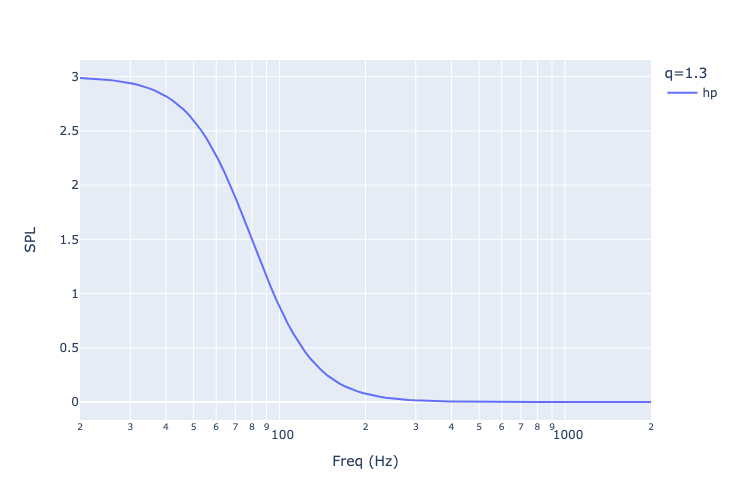

In [36]:
freq = np.logspace(1 + math.log10(2), 3 + math.log10(2), 100)
q = 1.3
peq = [(1.0, Biquad(5, 80, 48000, q, 3))]
peq_spl = peq_build(freq, peq)
print(np.max(peq_spl))

fig = pd.DataFrame(
    {
        "freq": freq,
        "hp": peq_spl,
    }
).plot.line(x="freq", y=["hp"])
fig.update_xaxes(type="log", title={"text": "Freq (Hz)"})
fig.update_yaxes(title={"text": "SPL"})
fig.update_layout(
    legend={
        "orientation": "v",
        "title": f"q={q:1.1f}",
    },
    height=500,
)
fig.show()